# Data Collection

The original dataset, US Domestic Flights Delay Prediction (2013 - 2018) (Source: [Kaggle](https://www.kaggle.com/datasets/gabrielluizone/us-domestic-flights-delay-prediction-2013-2018)), is provided as a 1.54 GB zip archive. Once decompressed, it contains 60 files with a total size of 13.6 GB. Each file represents one month of data, spanning from January 2014 to December 2018.

Steps for Data Collection and Cleaning:
*	Load the first file
*	Evaluate the data’s size and quality
*	Define the specific data required for the project
*	Develop a process for data organization and cleaning
*	Test the code on one month’s data file
*	Apply the code to all files
*	Aggregate the complete dataset
*	Test the data for accuracy, rectify any errors, and perform final cleaning

The archive file (csv_flight.zip) was downloaded and saved locally.

## Modules Initialisation and Functions Defenition

In [1]:
from  DataWrangling import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil import tz
from time import time
import pickle
import scipy.stats as st

## Loading the first file

In [2]:
home_dir = Path.cwd().parent
source_zip_file = home_dir / 'data' / 'interim' / 'csv_flight.zip'
data_file = 'csv_flight/report_2014_1.csv'

# reading the first file to evaluate the data
flights_2014_1 = load_data_from(source_zip_file, data_file)

## Data size

In [3]:
print('Shape of the one-month dataset:', flights_2014_1.shape)
print('It uses {:.2f} MB'.format(memory_usage(flights_2014_1)))
memory_usage_per_type(flights_2014_1)

Shape of the one-month dataset: (471949, 110)
It uses 717.16 MB
memory usage for number columns: 316.860 MB
memory usage for object columns: 395.352 MB
memory usage for datetimetz columns: 0.000 MB
memory usage for category columns: 0.000 MB
memory usage for bool columns: 1.350 MB


One month of data contains 471,949 rows and 110 columns, with a total memory size of 1.35 GB. The estimated size of the entire dataset, without reorganization or cleaning, may exceed 81 GB, which could be challenging to process locally. Therefore, a key goal of data preparation will be to reduce the dataset size without compromising its quality

## Feature Selection:  

1.	The original dataset contains 110 features, all of which were considered and evaluated during the feature selection process. Relevant features were selected, and appropriate data types were proposed for each.  

2.	The overall data quality is good. The dataset provides mostly comprehensive information, which will be examined in greater detail in the next section.  

3.	The logic surrounding canceled and diverted flights, as well as their impact on departure and arrival times, time delays, and elapsed times, has been identified and documented.  

4.	During the data transformation stage, special attention will be given to ensuring proper data types for the selected fields and addressing the ‘time-2400’ issue.  

5.	Delay times will be calculated as the difference between scheduled and actual arrival times, and their accuracy will be validated against elapsed times in the following sections.


## Evaluating the Accuracy of Scheduled and Actual Elapsed Times

The elapsed times (both scheduled and actual), along with departure and arrival times, are expected to play a crucial role in verifying the accuracy of both scheduled and actual departure and arrival times. Therefore, I will pay special attention to their quality and accuracy.

Given that there are 60 data files, it’s challenging to check all the data at once. I plan to start by examining one file, ‘report_2014_3.csv,’ to develop an approach for identifying and addressing potential errors. I will then apply this approach to the remaining files.

I chose March for this examination because it marks the start of Daylight Saving Time (DST), which may introduce errors into our data.

In [4]:
# These are fields I plan to examine
data_types = {
    'FlightDate':           'str',
    'Flight_Number_Reporting_Airline':  np.int16,
    'Origin':               'category',
    'Dest':                 'category',
    'CRSDepTime':           np.int16,
    'DepTime':              np.float32,
    'DepDelay':             np.float32,
    'CRSArrTime':           np.int16,
    'ArrTime':              np.float32,
    'ArrDelay':             np.float32,
    'Cancelled':            np.int8,        # boolean
    'Diverted':             np.int8,        # boolean
    'CRSElapsedTime':       np.float32,
    'ActualElapsedTime':    np.float32,
    'AirTime':              np.float32}

In [5]:
# The most important combinations of fields for analysis
Date_details = ['FlightDate']
DepTime_details = ['CRSDepTime', 'DepTime']
ArrTime_details = ['CRSArrTime', 'ArrTime']
DepTime_min_details = ['CRSDepTime_min', 'DepTime_min']
ArrTime_min_details = ['CRSArrTime_min', 'ArrTime_min']
ElapsedTime_details = ['CRSElapsedTime', 'ActualElapsedTime']
CRS_details = ['CRSDepTime', 'CRSArrTime', 'CRSElapsedTime']
CRS_min_details = ['CRSDepTime_min', 'CRSArrTime_min', 'CRSElapsedTime']
Route_datails = ['Origin', 'Dest']

In [6]:
# Loading some dataset just for tests
source_zip = home_dir / 'data' / 'interim' / 'csv_flight.zip'
source_path = 'csv_flight/report_'

flights = load_data_from(source_zip, source_path + '2014_3.csv', data_types)

To evaluate the accuracy of departure times, arrival times, and durations (both scheduled and actual), I need to calculate the UTC datetimes for both departures and arrivals. The original data includes the scheduled flight date, along with two sets of data (scheduled and actual) for departure and arrival times, as well as elapsed time.

To calculate the scheduled departure datetime in the local timezone, I will combine the ‘FlightDate’ with the departure time from ‘CRSDepTime.’ For the arrival time, I first need to determine the correct date, as flights may arrive the next day — or even the previous day — due to timezone differences. I plan to use a criterion based on the difference between departure and arrival times to indicate a change in date. A threshold for this time difference could serve as an effective indicator.

In the original dataset, all time data is provided in the HHMM format, which is not convenient for calculation and comparison purposes. I will convert it into a simple number of minutes from midnight.

In [7]:
flights['CRSDepTime_min'] = time_to_minutes(flights['CRSDepTime'])
flights['CRSArrTime_min'] = time_to_minutes(flights['CRSArrTime'])
flights['DepTime_min'] = time_to_minutes(flights['DepTime'])
flights['ArrTime_min'] = time_to_minutes(flights['ArrTime'])


My hypothesis is that all flights arriving the next day will have a significant negative difference between their arrival and departure times (in minutes). For example, if a flight departs at 1420 minutes (equivalent to 2:20 PM) and arrives at 75 minutes  (equivalent to 1:15 AM), it definitely arrived the next day. However, a negative difference can occur not only when the date changes but also when a flight departs from one timezone and arrives in another where the time difference with UTC is larger. In this case, the flight’s duration should be less than the time difference. I will examine this for short flights (less than 60 minutes) to determine an appropriate threshold.

In [8]:
# Filter for flights when CRS Arrival time is less of equal than CRS Departure time
CRSArr_less_than_CRSDep_min = flights['CRSArrTime_min'] <= flights['CRSDepTime_min']
less_than_60_min = flights['CRSElapsedTime'] < 60

# FOR TIMES EXPRESSED IN MINUTES !!!
# Flights where CRS Arrival time less than CRS Departure time AND a flight was less than 60 min
# To evaluate is it possible to 'travel in time' - to arrive the same day earlier 
flights[CRSArr_less_than_CRSDep_min & less_than_60_min][Date_details + CRS_min_details] \
    .sort_values('CRSElapsedTime').head()

,FlightDate,CRSDepTime_min,CRSArrTime_min,CRSElapsedTime
342964,2014-03-08,1430,29,39.0
342963,2014-03-07,1430,29,39.0
342961,2014-03-06,1430,29,39.0
211861,2014-03-01,1095,1081,46.0
319613,2014-03-28,763,750,47.0


We can see in the table above that the first three flights with a negative difference definitely arrived the next day. However, the last two flights also have a negative difference but could have arrived on the same day, just in a different timezone.

In [9]:
# ... and the END of the table
flights[CRSArr_less_than_CRSDep_min & less_than_60_min][Date_details + CRS_min_details] \
    .sort_values('CRSElapsedTime').tail()

,FlightDate,CRSDepTime_min,CRSArrTime_min,CRSElapsedTime
306171,2014-03-16,965,964,59.0
306170,2014-03-24,965,964,59.0
306169,2014-03-23,965,964,59.0
306176,2014-03-21,965,964,59.0
392396,2014-03-01,1115,1114,59.0


In this table, all flights have a negative difference between arrival and departure times, but all of them arrived on the same day.

In [10]:
# Calculation of the difference between departure and arrival time 
flights['CRS_Arr_minus_Dep'] = flights['CRSArrTime_min'] - flights['CRSDepTime_min'] 

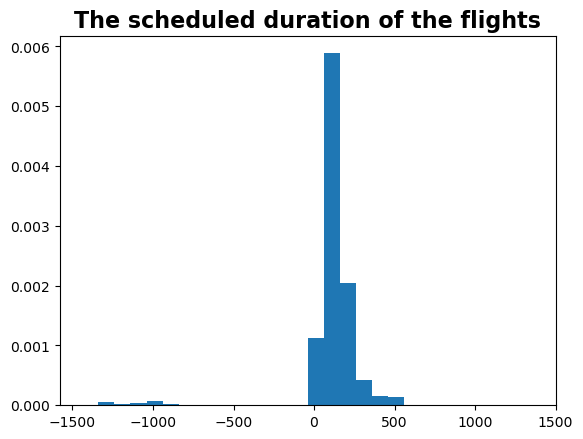

In [11]:
# Examine the difference between CRS Arrival and Departure times
bins = np.arange(-1440, 1440, 100)
plt.hist(flights['CRS_Arr_minus_Dep'], density=True,  bins = bins)
plt.title('The scheduled duration of the flights', fontsize = 16, fontweight = 'bold')
plt.show()

We can see that the time difference between arrival and departure times can be negative or positive, but there appears to be a notable gap in the negative values. Let’s zoom in on this part of the histogram.

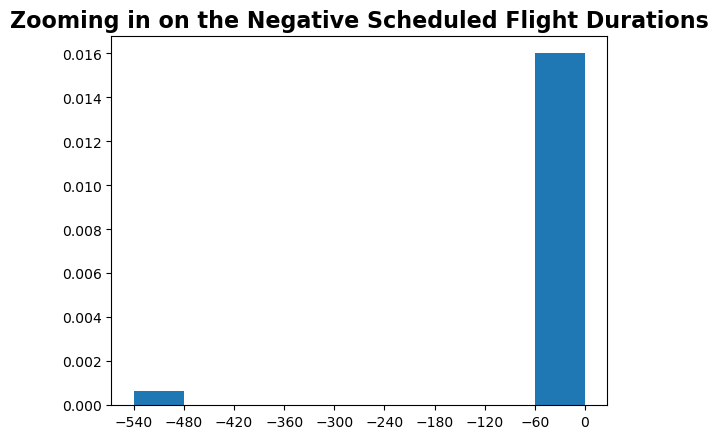

In [12]:
# Examine MORE CLOSELY the difference between CRS Arrival and Departure times 
bins = np.arange(-540, 60, 60)
plt.hist(flights['CRS_Arr_minus_Dep'], density=True,  bins = bins)
plt.xticks(bins)
plt.title('Zooming in on the Negative Scheduled Flight Durations', fontsize = 16, fontweight = 'bold')
plt.show()

We can see that there is no negative values between -8 hours (-480 min) and -1 hour (-60 min). However, to be sure let's examine the data.

In [13]:
# Are there any values between -900 and -200
diff_between_900_200 = (flights['CRS_Arr_minus_Dep'] > -480) & (flights['CRS_Arr_minus_Dep'] < -60)
print(flights[diff_between_900_200])

del(diff_between_900_200)

Empty DataFrame
Columns: [FlightDate, Flight_Number_Reporting_Airline, Origin, Dest, CRSDepTime, DepTime, DepDelay, CRSArrTime, ArrTime, ArrDelay, Cancelled, Diverted, CRSElapsedTime, ActualElapsedTime, AirTime, CRSDepTime_min, CRSArrTime_min, DepTime_min, ArrTime_min, CRS_Arr_minus_Dep]
Index: []


Yes, there are no values between -480 and -60 minutes. It is possible to “travel in time” only for a maximum of 60 minutes. All other differences occur when flights take off before midnight and land the next day. I can use a threshold of -60 minutes to adjust the departure date by adding one day in order to calculate the arrival date.

In [14]:
# Are there any values between -900 and -200
diff_greater_than_1300 = (flights['CRS_Arr_minus_Dep'] > 1300)
print(flights[diff_greater_than_1300])

del(diff_greater_than_1300)

Empty DataFrame
Columns: [FlightDate, Flight_Number_Reporting_Airline, Origin, Dest, CRSDepTime, DepTime, DepDelay, CRSArrTime, ArrTime, ArrDelay, Cancelled, Diverted, CRSElapsedTime, ActualElapsedTime, AirTime, CRSDepTime_min, CRSArrTime_min, DepTime_min, ArrTime_min, CRS_Arr_minus_Dep]
Index: []


There are no records with a positive difference greater than 1,300 minutes. However, when this occurs, it indicates that the flight arrived the previous day due to a timezone difference. I will use this information to calculate arrival dates.

### Calculating dates of departure and arrivel timezone naive 

#### Scheduled dates

In [15]:
# converting CRS times (departure and arrival) into datetime with correct arrival date - the previous, the same or the next day
flights['CRSDepDT'], flights['CRSArrDT'] = get_CRS_datetime(flights['FlightDate'], 
                                                            flights['CRSDepTime_min'], 
                                                            flights['CRSArrTime_min'])

In [16]:

# Check for actual departure and arrival datetimes 
pd.set_option('display.width', 200)

CRS_Arrived_next_day = flights['CRSArrTime_min'] - flights['CRSDepTime_min']  <= -60
CRS_Arrived_previous_day = flights['CRSArrTime_min'] - flights['CRSDepTime_min']  >= 1380
fields_to_check = ['FlightDate', 'CRSDepDT', 'CRSDepTime', 'CRSArrDT', 'CRSArrTime']
print('Flights arrived next day after departure\n', flights[CRS_Arrived_next_day][fields_to_check].head())
print('\nFlights arrived the same day as departured\n', flights[~CRS_Arrived_next_day][fields_to_check].head())
print('\nFlights arrived the previous day as departured\n', flights[CRS_Arrived_previous_day][fields_to_check].head())

pd.reset_option('display.width')

Flights arrived next day after departure
     FlightDate            CRSDepDT  CRSDepTime            CRSArrDT  CRSArrTime
259 2014-03-20 2014-03-20 20:40:00        2040 2014-03-21 00:05:00           5
529 2014-03-20 2014-03-20 21:50:00        2150 2014-03-21 00:15:00          15
559 2014-03-20 2014-03-20 17:55:00        1755 2014-03-21 00:30:00          30
569 2014-03-20 2014-03-20 17:15:00        1715 2014-03-21 00:20:00          20
578 2014-03-20 2014-03-20 17:40:00        1740 2014-03-21 00:50:00          50

Flights arrived the same day as departured
   FlightDate            CRSDepDT  CRSDepTime            CRSArrDT  CRSArrTime
0 2014-03-20 2014-03-20 07:00:00         700 2014-03-20 08:25:00         825
1 2014-03-20 2014-03-20 16:50:00        1650 2014-03-20 18:10:00        1810
2 2014-03-20 2014-03-20 09:05:00         905 2014-03-20 10:25:00        1025
3 2014-03-20 2014-03-20 07:05:00         705 2014-03-20 07:25:00         725
4 2014-03-20 2014-03-20 21:10:00        2110 2014-03-2

#### Actual dates

When calculating actual dates, we must consider that even the departure date can differ from the ‘FlightDate’ in the dataset. This date represents the scheduled time, but the actual time can shift to the next or previous day due to positive or negative flight delays.

In [17]:
flights['ActDepDT'], flights['ActArrDT'] = get_Actual_datetime(flights['FlightDate'], 
                                                                flights['CRSDepTime_min'],
                                                                flights['DepTime_min'],
                                                                flights['ArrTime_min'],
                                                                flights['DepDelay'])

In [18]:
# Check for actual departure and arrival datetimes
Arrived_next_day = flights['ArrTime_min'] - flights['DepTime_min']  <= -60
Arrived_previous_day = flights['ArrTime_min'] - flights['DepTime_min']  >= 1380
fields_to_check = ['FlightDate', 'CRSDepTime', 'DepDelay', 'ActDepDT', 'DepTime', 'ActArrDT', 'ArrTime']

with pd.option_context('display.width', 100):
    print('\nFlights arrived next day after departure\n', flights[Arrived_next_day][fields_to_check].head())
    print('\nFlights arrived the same day as departured\n', flights[~Arrived_next_day][fields_to_check].head())
    print('\nFlights arrived the previous day as departured\n', flights[Arrived_previous_day][fields_to_check].head())


Flights arrived next day after departure
     FlightDate  CRSDepTime  DepDelay            ActDepDT  DepTime            ActArrDT  ArrTime
80  2014-03-20        2130      59.0 2014-03-20 22:29:00   2229.0 2014-03-21 00:13:00     13.0
94  2014-03-20        2110     145.0 2014-03-20 23:35:00   2335.0 2014-03-21 01:58:00    158.0
108 2014-03-20        1910     236.0 2014-03-20 23:06:00   2306.0 2014-03-21 00:16:00     16.0
204 2014-03-20        1915     224.0 2014-03-20 22:59:00   2259.0 2014-03-21 01:22:00    122.0
259 2014-03-20        2040      29.0 2014-03-20 21:09:00   2109.0 2014-03-21 00:22:00     22.0

Flights arrived the same day as departured
   FlightDate  CRSDepTime  DepDelay            ActDepDT  DepTime            ActArrDT  ArrTime
0 2014-03-20         700       0.0 2014-03-20 07:00:00    700.0 2014-03-20 08:11:00    811.0
1 2014-03-20        1650      90.0 2014-03-20 18:20:00   1820.0 2014-03-20 19:30:00   1930.0
2 2014-03-20         905       0.0 2014-03-20 09:05:00    905.0

#### Converting datetimes to UTC timezone

In [19]:
# Converting scheduled (CRS) departure and arrival times into UTC timezone datetime
flights['CRSDep_UTC'] = convert_column_to_UTC(flights, 'CRSDepDT', 'Origin')
flights['CRSArr_UTC'] = convert_column_to_UTC(flights, 'CRSArrDT', 'Dest')

# Converting actual departure times into UTC timezone datetime
# We have to filter for non-NA values because astimezone doesn't work wiht NaN/NaT
nonNA_Dep = ~flights['ActDepDT'].isna()
flights['ActDep_UTC'] = pd.NaT
flights['ActDep_UTC'] = flights['ActDep_UTC'].dt.tz_localize(tz.UTC)
flights.loc[nonNA_Dep, 'ActDep_UTC'] = convert_column_to_UTC(flights[nonNA_Dep], 'ActDepDT', 'Origin')

# Converting actual arrival times into UTC timezone datetime
# We have to filter for non-NA values because astimezone doesn't work wiht NaN/NaT
nonNA_Arr = ~flights['ActArrDT'].isna()
flights['ActArr_UTC'] = pd.NaT
flights['ActArr_UTC'] = flights['ActArr_UTC'].dt.tz_localize(tz.UTC)
flights.loc[nonNA_Arr, 'ActArr_UTC'] = convert_column_to_UTC(flights[nonNA_Arr], 'ActArrDT', 'Dest')

In [20]:
with pd.option_context('display.width', 100):
    # Check CRS
    fields_to_check_UTC_CRS = ['CRSDepDT', 'CRSDep_UTC', 'CRSArrDT', 'CRSArr_UTC']
    print(flights[fields_to_check_UTC_CRS].head())

    # Check ACTUAL
    fields_to_check_UTC_Act = ['ActDepDT', 'ActDep_UTC', 'ActArrDT', 'ActArr_UTC']
    print(flights[fields_to_check_UTC_Act].head())

             CRSDepDT                CRSDep_UTC            CRSArrDT                CRSArr_UTC
0 2014-03-20 07:00:00 2014-03-20 13:00:00+00:00 2014-03-20 08:25:00 2014-03-20 14:25:00+00:00
1 2014-03-20 16:50:00 2014-03-20 22:50:00+00:00 2014-03-20 18:10:00 2014-03-21 00:10:00+00:00
2 2014-03-20 09:05:00 2014-03-20 15:05:00+00:00 2014-03-20 10:25:00 2014-03-20 16:25:00+00:00
3 2014-03-20 07:05:00 2014-03-20 13:05:00+00:00 2014-03-20 07:25:00 2014-03-20 14:25:00+00:00
4 2014-03-20 21:10:00 2014-03-21 03:10:00+00:00 2014-03-20 21:25:00 2014-03-21 04:25:00+00:00
             ActDepDT                ActDep_UTC            ActArrDT                ActArr_UTC
0 2014-03-20 07:00:00 2014-03-20 13:00:00+00:00 2014-03-20 08:11:00 2014-03-20 14:11:00+00:00
1 2014-03-20 18:20:00 2014-03-21 00:20:00+00:00 2014-03-20 19:30:00 2014-03-21 01:30:00+00:00
2 2014-03-20 09:05:00 2014-03-20 15:05:00+00:00 2014-03-20 10:18:00 2014-03-20 16:18:00+00:00
3 2014-03-20 07:02:00 2014-03-20 13:02:00+00:00 2014-03-20 0

#### Calculating scheduled and actual elapsed times based on UTC departure and arrival

In [21]:
# Calculating Elapsed time based on UTC times
flights['UTCElapsedTime_CRS'] = (flights['CRSArr_UTC'] - flights['CRSDep_UTC']).dt.total_seconds() / 60

flights.loc[nonNA_Arr, 'UTCElapsedTime_Act'] = pd.to_timedelta((flights.loc[nonNA_Arr, 'ActArr_UTC'] - 
                                                                flights.loc[nonNA_Arr, 'ActDep_UTC'])).dt.total_seconds() / 60

In [22]:
# The difference between UTC-based Elapsed time and CRS/ACTUAL Elapsed time
flights['diff_CRS'] = flights['UTCElapsedTime_CRS'] - flights['CRSElapsedTime']
flights['diff_Act'] = flights['UTCElapsedTime_Act'] - flights['ActualElapsedTime']

### Examining the accuracy of CRS Elapsed time

In [23]:
# Examine the flights having difference between UTC-Based and CRS Elapsed times 
diff_not_zero = flights[flights['diff_CRS'] != 0][fields_to_check_UTC_CRS + ['CRSElapsedTime', 'UTCElapsedTime_CRS']]
print('There are', len(diff_not_zero), 'flights where CRS Elapsed time differ from CRS Elapsed time culculated based on UTC')
print(diff_not_zero.head())

del(diff_not_zero)

There are 76 flights where CRS Elapsed time differ from CRS Elapsed time culculated based on UTC
                 CRSDepDT                CRSDep_UTC            CRSArrDT  \
86022 2014-03-08 23:00:00 2014-03-09 07:00:00+00:00 2014-03-09 01:50:00   
86031 2014-03-08 23:50:00 2014-03-09 07:50:00+00:00 2014-03-09 03:46:00   
86033 2014-03-08 23:05:00 2014-03-09 07:05:00+00:00 2014-03-09 01:56:00   
86262 2014-03-08 23:15:00 2014-03-09 09:15:00+00:00 2014-03-09 08:07:00   
86265 2014-03-08 23:55:00 2014-03-09 09:55:00+00:00 2014-03-09 08:31:00   

                     CRSArr_UTC  CRSElapsedTime  UTCElapsedTime_CRS  
86022 2014-03-09 10:50:00+00:00           290.0               230.0  
86031 2014-03-09 11:46:00+00:00           296.0               236.0  
86033 2014-03-09 10:56:00+00:00           291.0               231.0  
86262 2014-03-09 15:07:00+00:00           412.0               352.0  
86265 2014-03-09 15:31:00+00:00           396.0               336.0  


In [24]:
flights['diff_CRS'].value_counts()

diff_CRS
 0.0       503682
 1440.0        31
-1440.0        31
-60.0          13
-36.0           1
Name: count, dtype: int64

There are 76 flights in the dataset that have differences between UTC and CRS elapsed time.

Let’s take a detailed look at one of these flights: the first one from the table above, with an ID of 86022, which has a -60 minute difference between UTC and CRS elapsed times.

In [25]:
# Let's take a look on the first flight with diffeence
flights.iloc[86022]

FlightDate                               2014-03-08 00:00:00
Flight_Number_Reporting_Airline                          103
Origin                                                   SEA
Dest                                                     ANC
CRSDepTime                                              2300
DepTime                                               2347.0
DepDelay                                                47.0
CRSArrTime                                               150
ArrTime                                                206.0
ArrDelay                                                16.0
Cancelled                                              False
Diverted                                               False
CRSElapsedTime                                         290.0
ActualElapsedTime                                      259.0
AirTime                                                241.0
CRSDepTime_min                                          1380
CRSArrTime_min          

First, we see that this flight took place on March 9th, 2014—the spring start of DST—and the difference between UTC and CRS elapsed times is exactly 60 minutes. But which time is correct? Let’s take a look at similar flights on other days.

In [26]:
flights[(flights['Flight_Number_Reporting_Airline'] == 103) &
         (flights['Origin'] == 'SEA')][['CRSArrTime', 'CRSElapsedTime', 'UTCElapsedTime_CRS', 'diff_CRS']]

,CRSArrTime,CRSElapsedTime,UTCElapsedTime_CRS,diff_CRS
84659,150,230.0,230.0,0.0
85219,150,230.0,230.0,0.0
85612,150,230.0,230.0,0.0
86022,150,290.0,230.0,-60.0
87954,2147,212.0,212.0,0.0
88114,150,230.0,230.0,0.0
88520,150,230.0,230.0,0.0
88902,150,230.0,230.0,0.0
89349,2147,212.0,212.0,0.0
90881,2147,212.0,212.0,0.0


It seems that the only flight with a difference is the flight that landed on March 9th, 2014, and the UTC-based elapsed time is correct (CRSElapsedTime has the wrong value for the DST day). Let’s examine other flights with a difference of 60 minutes.

In [27]:
diff_60_min = flights[flights['diff_CRS'] == -60][['CRSDepDT', 'CRSArrDT', 'CRSElapsedTime', 'UTCElapsedTime_CRS', 'diff_CRS']]
with pd.option_context('display.width', 100):
    print(len(diff_60_min), 'records')
    print(diff_60_min)

del(diff_60_min)

13 records
                 CRSDepDT            CRSArrDT  CRSElapsedTime  UTCElapsedTime_CRS  diff_CRS
86022 2014-03-08 23:00:00 2014-03-09 01:50:00           290.0               230.0     -60.0
86031 2014-03-08 23:50:00 2014-03-09 03:46:00           296.0               236.0     -60.0
86033 2014-03-08 23:05:00 2014-03-09 01:56:00           291.0               231.0     -60.0
86262 2014-03-08 23:15:00 2014-03-09 08:07:00           412.0               352.0     -60.0
86265 2014-03-08 23:55:00 2014-03-09 08:31:00           396.0               336.0     -60.0
86289 2014-03-08 20:55:00 2014-03-09 05:55:00           420.0               360.0     -60.0
86293 2014-03-08 22:30:00 2014-03-09 06:50:00           440.0               380.0     -60.0
86296 2014-03-08 22:10:00 2014-03-09 06:55:00           405.0               345.0     -60.0
86303 2014-03-08 23:55:00 2014-03-09 08:58:00           423.0               363.0     -60.0
86307 2014-03-08 20:50:00 2014-03-09 06:09:00           379.0        

We can see that all flights with a -60 minute difference between UTC and CRS elapsed times occurred during DST. There are 13 such records in the dataset.

We can conclude that the CRS elapsed time is incorrect for all 13 flights that occurred during the start of DST.

This explains the discrepancy between UTC and CRS elapsed times for 13 out of the 76 flights in the dataset. But what about the remaining flights with a difference?

In [28]:
flights['UTCElapsedTime_CRS'].describe()

count    503758.000000
mean        137.281445
std          75.220284
min        -975.000000
25%          84.000000
50%         119.000000
75%         170.000000
max        1875.000000
Name: UTCElapsedTime_CRS, dtype: float64

There is another interesting fact - some flights has also a negative UTC elapsed time! How is this possible?

In [29]:
error_less_0 = flights[flights['UTCElapsedTime_CRS'] < 0]
print('Number of flihgts with negative UTC-based duration:', len(error_less_0))
error_less_0[
    ['CRSDepTime', 
     'Origin', 
     'CRSArrTime', 
     'Dest', 
     'CRSElapsedTime', 
     'UTCElapsedTime_CRS', 
     'diff_CRS']]

Number of flihgts with negative UTC-based duration: 31


,CRSDepTime,Origin,CRSArrTime,Dest,CRSElapsedTime,UTCElapsedTime_CRS,diff_CRS
355885,1415,HNL,1800,GUM,465.0,-975.0,-1440.0
356594,1415,HNL,1800,GUM,465.0,-975.0,-1440.0
357533,1405,HNL,1755,GUM,470.0,-970.0,-1440.0
359004,1405,HNL,1755,GUM,470.0,-970.0,-1440.0
363144,1405,HNL,1755,GUM,470.0,-970.0,-1440.0
363988,1405,HNL,1755,GUM,470.0,-970.0,-1440.0
365214,1405,HNL,1755,GUM,470.0,-970.0,-1440.0
366081,1405,HNL,1755,GUM,470.0,-970.0,-1440.0
367783,1405,HNL,1755,GUM,470.0,-970.0,-1440.0
368046,1405,HNL,1755,GUM,470.0,-970.0,-1440.0


There are 31 flights with a negative UTC elapsed time. Previously, we analyzed the differences between UTC and CRS elapsed times and found that these 31 flights had a -1440 minute difference. This indicates that the same flights are involved. A difference of 1440 minutes is equivalent to 24 hours.

Interestingly, all 31 flights were from HNL to GUM. HNL is in the UTC-10 timezone, while GUM is in the UTC+10 timezone, meaning these two airports are located across the International Date Line (IDL).

In [30]:
with pd.option_context('display.width', 120):
    print(error_less_0[['CRSDep_UTC', 'CRSDepTime', 'Origin', 'CRSArr_UTC', 'CRSArrTime', 'Dest', 'diff_CRS']].head())

del(error_less_0)

                      CRSDep_UTC  CRSDepTime Origin                CRSArr_UTC  CRSArrTime Dest  diff_CRS
355885 2014-04-01 00:15:00+00:00        1415    HNL 2014-03-31 08:00:00+00:00        1800  GUM   -1440.0
356594 2014-03-31 00:15:00+00:00        1415    HNL 2014-03-30 08:00:00+00:00        1800  GUM   -1440.0
357533 2014-03-28 00:05:00+00:00        1405    HNL 2014-03-27 07:55:00+00:00        1755  GUM   -1440.0
359004 2014-03-29 00:05:00+00:00        1405    HNL 2014-03-28 07:55:00+00:00        1755  GUM   -1440.0
363144 2014-03-27 00:05:00+00:00        1405    HNL 2014-03-26 07:55:00+00:00        1755  GUM   -1440.0


The simplest way to correct this is to identify all flights with UTC departures less than UTC arrivals by -1440 minutes, then add 24 x 60 minutes to both the UTC elapsed time and the arrival times (scheduled and actual).

There ara other flights which have the "oposite" difference - they differ on +1440 minutes. 

In [31]:
error_plus_1440 = flights[flights['diff_CRS'] == 1440]
with pd.option_context('display.width', 120):
    print(len(error_plus_1440))
    print(error_plus_1440[['CRSDep_UTC', 'CRSDepTime', 'Origin', 'CRSArr_UTC', 'CRSArrTime', 'Dest', 'diff_CRS']])

del(error_plus_1440)

31
                      CRSDep_UTC  CRSDepTime Origin                CRSArr_UTC  CRSArrTime Dest  diff_CRS
355883 2014-03-30 20:30:00+00:00         630    GUM 2014-04-01 03:45:00+00:00        1745  HNL    1440.0
356592 2014-03-29 20:30:00+00:00         630    GUM 2014-03-31 03:45:00+00:00        1745  HNL    1440.0
357531 2014-03-26 20:40:00+00:00         640    GUM 2014-03-28 03:40:00+00:00        1740  HNL    1440.0
359002 2014-03-27 20:40:00+00:00         640    GUM 2014-03-29 03:40:00+00:00        1740  HNL    1440.0
363142 2014-03-25 20:40:00+00:00         640    GUM 2014-03-27 03:40:00+00:00        1740  HNL    1440.0
363986 2014-03-23 20:40:00+00:00         640    GUM 2014-03-25 03:40:00+00:00        1740  HNL    1440.0
365212 2014-03-24 20:40:00+00:00         640    GUM 2014-03-26 03:40:00+00:00        1740  HNL    1440.0
366079 2014-03-22 20:40:00+00:00         640    GUM 2014-03-24 03:40:00+00:00        1740  HNL    1440.0
367781 2014-03-19 20:40:00+00:00         640    GUM 

All these flights are return flights from GUM to HNL across the International Date Line (IDL). The remedy is similar: subtract 24 x 60 (1440) minutes from the UTC elapsed time and Arrival times.

There is just one flight with an unexamined difference remaining.

In [32]:
error_minus_36 = flights[flights['diff_CRS'] == -36]
print(len(error_minus_36), 'records')
print(error_minus_36[['Flight_Number_Reporting_Airline', 'CRSDep_UTC', 'CRSDepTime', 'Origin', 'CRSArr_UTC', 
            'CRSArrTime', 'Dest', 'CRSElapsedTime', 'UTCElapsedTime_CRS', 
            'ActualElapsedTime', 'diff_CRS', 'Cancelled', 'Diverted']].T)

del(error_minus_36)

1 records
                                                    253577
Flight_Number_Reporting_Airline                        317
CRSDep_UTC                       2014-03-30 14:05:00+00:00
CRSDepTime                                             805
Origin                                                 DEN
CRSArr_UTC                       2014-03-30 16:14:00+00:00
CRSArrTime                                             914
Dest                                                   PSP
CRSElapsedTime                                       165.0
UTCElapsedTime_CRS                                   129.0
ActualElapsedTime                                      NaN
diff_CRS                                             -36.0
Cancelled                                            False
Diverted                                              True


In [33]:
flights[(flights['Flight_Number_Reporting_Airline'] == 317) &
        (flights['Origin'] == 'DEN') &
        (flights['Dest'] == 'PSP')] [['CRSElapsedTime', 'UTCElapsedTime_CRS', 'diff_CRS']]

,CRSElapsedTime,UTCElapsedTime_CRS,diff_CRS
246801,129.0,129.0,0.0
247742,129.0,129.0,0.0
247840,129.0,129.0,0.0
248214,129.0,129.0,0.0
248832,129.0,129.0,0.0
249571,129.0,129.0,0.0
250063,129.0,129.0,0.0
250962,129.0,129.0,0.0
251072,129.0,129.0,0.0
251378,129.0,129.0,0.0


In this case we can see that CRS Elapsed time is:
1. also inconsistent with CRS Departure and CRS Arrival times
2. all other flights for this route have the equal CRS and UTC elapsed times which is 129 minutes  

So this can be an error

### Checking ACTUAL time

In [34]:
flights['diff_Act'].value_counts()

diff_Act
 0.0       492965
-1440.0        30
 1440.0        30
-60.0          15
-6.0            1
 5.0            1
-51.0           1
Name: count, dtype: int64

It appears that the actual elapsed time shows the same differences as the scheduled elapsed time between the two types of flight duration: one calculated using UTC arrival and departure times, and the other based on the ActualElapsedTime provided in the dataset. Let’s take a closer look.

The total number of discrepancies is 78, with the following breakdown:
*	+/-1440 minutes: 60 records, likely related to flights crossing the International Date Line (IDL) from HNL to GUM and back.
*	-60 minutes: 15 records, possibly due to flights occurring during the transition to Daylight Saving Time (DST) in the spring.
*	Other: 3 records with small, random differences, which could be attributed to minor errors.

In [35]:
error_1440 = flights[flights['diff_Act'].isin([1440, -1440])]
print('There are:', len(error_1440), 'records with differenc +/-1440 min (equal to 24 hours)')
print('Which airports are presented among these flights? -', *set(error_1440['Origin']).union(set(error_1440['Origin'])))

del(error_1440)

There are: 60 records with differenc +/-1440 min (equal to 24 hours)
Which airports are presented among these flights? - HNL GUM


All these flights are again between two airports across IDL. We already know this problem and know how to fix it. 

In [36]:
# Let's check the flights with difference between actual and UTC-based actual duration equal to -60 minutes
fields_to_check = ['Flight_Number_Reporting_Airline', 'ActDepDT', 'ActArrDT',
                   'Origin', 'Dest', 'ActualElapsedTime', 'UTCElapsedTime_Act']
error_60 = flights[flights['diff_Act'] == -60][fields_to_check]

# Converting datetimes naive to tz-aware datetimes
error_60['ActDepDT_tz'] = add_local_tz(error_60, 'ActDepDT', 'Origin')
error_60['ActArrDT_tz'] = add_local_tz(error_60, 'ActArrDT', 'Dest')

with pd.option_context('display.width', 200):
    print(error_60[fields_to_check])
    print('There are', len(error_60), 'flights with -60 minutes difference')

        Flight_Number_Reporting_Airline            ActDepDT            ActArrDT Origin Dest  ActualElapsedTime  UTCElapsedTime_Act
86031                               121 2014-03-09 00:10:00 2014-03-09 03:39:00    SEA  ANC              269.0               209.0
86033                               125 2014-03-08 23:03:00 2014-03-09 01:38:00    SEA  FAI              275.0               215.0
86262                               816 2014-03-08 23:15:00 2014-03-09 07:28:00    LIH  SEA              373.0               313.0
86265                               822 2014-03-08 23:50:00 2014-03-09 07:42:00    OGG  PDX              352.0               292.0
86289                               864 2014-03-08 21:06:00 2014-03-09 05:21:00    HNL  SEA              375.0               315.0
86293                               871 2014-03-08 22:22:00 2014-03-09 06:51:00    HNL  ANC              449.0               389.0
86296                               878 2014-03-08 21:56:00 2014-03-09 06:05:00    

All these flights departured before the transition to DST and arrived after it (except one flight 125 from SEA to FAI). This is the reason they have a wrong ActualElapsedTime. It's worth to mention that theirs arrival time is correct because UTC-based durations have correct values (UTC-based duration is calculated based on departure and arrival times).


In [37]:
flights[(flights['Flight_Number_Reporting_Airline'] == 125) &
         (flights['Origin'] == 'SEA') &
         (flights['Dest'] == 'FAI')] [['Flight_Number_Reporting_Airline', 
                                       'ActDepDT', 'ActArrDT', 
                                       'Origin', 'Dest', 
                                       'ActualElapsedTime', 'UTCElapsedTime_Act', 'diff_CRS']]

,Flight_Number_Reporting_Airline,ActDepDT,ActArrDT,Origin,Dest,ActualElapsedTime,UTCElapsedTime_Act,diff_CRS
84672,125,2014-03-06 22:57:00,2014-03-07 01:34:00,SEA,FAI,217.0,217.0,0.0
85230,125,2014-03-01 23:05:00,2014-03-02 01:50:00,SEA,FAI,225.0,225.0,0.0
85624,125,2014-03-02 23:04:00,2014-03-03 01:36:00,SEA,FAI,212.0,212.0,0.0
86033,125,2014-03-08 23:03:00,2014-03-09 01:38:00,SEA,FAI,275.0,215.0,-60.0
88127,125,2014-03-03 23:05:00,2014-03-04 01:42:00,SEA,FAI,217.0,217.0,0.0
88533,125,2014-03-04 22:56:00,2014-03-05 01:38:00,SEA,FAI,222.0,222.0,0.0
88915,125,2014-03-05 23:10:00,2014-03-06 01:55:00,SEA,FAI,225.0,225.0,0.0
96547,125,2014-03-07 23:04:00,2014-03-08 01:29:00,SEA,FAI,205.0,205.0,0.0


Flight 125 from SEA to FAI has the incorrect Actual Elapsed Time only on March 9, 2014. On all other days, the actual elapsed times are equal to the UTC-based actual elapsed times.

Let's analyse remaining flights with differencies

In [38]:
fields_to_check = ['Flight_Number_Reporting_Airline',
       'ActDepDT', 
       'ActArrDT',
       'Origin', 
       'Dest', 
       'ActDep_UTC',
       'ActArr_UTC',
       'diff_Act', 
       'ActualElapsedTime', 
       'UTCElapsedTime_Act']
other = flights[(flights['diff_Act'] > -60) & (flights['diff_Act'] < 10) & (flights['diff_Act'] != 0)]
print(len(other))
other[fields_to_check].T

3


,86022,86023,233975
Flight_Number_Reporting_Airline,103,106,5702
ActDepDT,2014-03-08 23:47:00,2014-03-08 21:33:00,2014-03-09 00:20:00
ActArrDT,2014-03-09 02:06:00,2014-03-09 02:55:00,2014-03-09 02:51:00
Origin,SEA,ANC,ORD
Dest,ANC,SEA,CAE
ActDep_UTC,2014-03-09 07:47:00+00:00,2014-03-09 06:33:00+00:00,2014-03-09 06:20:00+00:00
ActArr_UTC,2014-03-09 12:00:00+00:00,2014-03-09 10:00:00+00:00,2014-03-09 07:00:00+00:00
diff_Act,-6.0,5.0,-51.0
ActualElapsedTime,259.0,202.0,91.0
UTCElapsedTime_Act,253.0,207.0,40.0


First of all, we notice that all these differences appear again on the spring DST start date.
Secondly, it looks like the first two flights have minor errors that we can disregard, and we can use UTC elapsed time instead of Actual elapsed time. However, the third flight has a significant difference. Let’s examine it in more detail.

In [39]:
flights[(flights['Flight_Number_Reporting_Airline'] == 5702) &\
        (flights['Origin'] == 'ORD') & (flights['Dest'] == 'CAE')][fields_to_check]

,Flight_Number_Reporting_Airline,ActDepDT,ActArrDT,Origin,Dest,ActDep_UTC,ActArr_UTC,diff_Act,ActualElapsedTime,UTCElapsedTime_Act
233969,5702,NaT,NaT,ORD,CAE,NaT,NaT,NaN,NaN,NaN
233970,5702,NaT,NaT,ORD,CAE,NaT,NaT,NaN,NaN,NaN
233971,5702,2014-03-01 21:45:00,2014-03-02 00:25:00,ORD,CAE,2014-03-02 03:45:00+00:00,2014-03-02 05:25:00+00:00,0.0,100.0,100.0
233972,5702,2014-03-04 20:47:00,2014-03-04 23:40:00,ORD,CAE,2014-03-05 02:47:00+00:00,2014-03-05 04:40:00+00:00,0.0,113.0,113.0
233973,5702,2014-03-02 18:22:00,2014-03-02 21:09:00,ORD,CAE,2014-03-03 00:22:00+00:00,2014-03-03 02:09:00+00:00,0.0,107.0,107.0
233974,5702,2014-03-06 21:53:00,2014-03-07 00:54:00,ORD,CAE,2014-03-07 03:53:00+00:00,2014-03-07 05:54:00+00:00,0.0,121.0,121.0
233975,5702,2014-03-09 00:20:00,2014-03-09 02:51:00,ORD,CAE,2014-03-09 06:20:00+00:00,2014-03-09 07:00:00+00:00,-51.0,91.0,40.0
233976,5702,2014-03-07 18:08:00,2014-03-07 20:52:00,ORD,CAE,2014-03-08 00:08:00+00:00,2014-03-08 01:52:00+00:00,0.0,104.0,104.0
233977,5702,2014-03-15 19:36:00,2014-03-15 22:20:00,ORD,CAE,2014-03-16 00:36:00+00:00,2014-03-16 02:20:00+00:00,0.0,104.0,104.0
233978,5702,2014-03-13 18:37:00,2014-03-13 21:12:00,ORD,CAE,2014-03-13 23:37:00+00:00,2014-03-14 01:12:00+00:00,0.0,95.0,95.0


We observe that the same flight on other days has a duration close to the actual elapsed time recorded on March 9th. The elapsed time based on UTC, however, is significantly different from the real duration, which suggests that either the actual departure or arrival time (or both) is incorrect. There are several options to address this, such as adjusting the departure or arrival time based on the average duration of similar flights. However, due to the insignificance of this error (1 out of almost 500k flights in total, and 25 flights on this route in the same month), the simplest solution is to drop this record on the next stage.

### Conclusions for the Evaluation of the Accuracy of Scheduled and Actual Elapsed Times

1.	Most of the data is accurate.
2.	Flights across the International Date Line (IDL), particularly between GUM and HNL airports, require a corrction for 1,440 minutes (24 hours) due to the date change.
3.	The start (and probably the end) of Daylight Saving Time (DST) creates minor errors in elapsed time calculations and requires correction.
4.	There is an absolute minority of flights that have discrepancies between elapsed time and departure and arrival times (3 flights out of more than 500,000 records for March 2014).

## Data transformation

### Preprocessing all 60 data files (one file - one month)

In [40]:
fields_to_load = {
    # 'Year':                 np.int16,               
    # 'Quarter':              np.int8,                
    # 'Month':                np.int8,                
    # 'DayofMonth':           np.int8,
    # 'DayOfWeek':            np.int8,
    'FlightDate':           'str',
    'Reporting_Airline':    'category',
    'Flight_Number_Reporting_Airline':  np.int16,
    # 'OriginAirportID':      'category',
    'Origin':               'category',
    # 'DestAirportID':        'category',
    'Dest':                 'category',
    'CRSDepTime':           np.int16,
    'DepTime':              'float32',
    'DepDelay':             'float32',
    'DepartureDelayGroups': 'category',
    'DepTimeBlk':           'category',
    'CRSArrTime':           np.int16,
    'ArrTime':              'float32',
    'ArrDelay':             'float32',
    # 'Distance':             'float32',
    'ArrivalDelayGroups':   'category',
    'ArrTimeBlk':           'category',
    'Cancelled':            np.int8,        # boolean
    'CancellationCode':     'category',
    'Diverted':             np.int8,        # boolean
    'CarrierDelay':         'float32',
    'WeatherDelay':         'float32',
    'NASDelay':             'float32',
    'SecurityDelay':        'float32',
    'LateAircraftDelay':    'float32',
    'CRSElapsedTime':       'float32',
    'ActualElapsedTime':    'float32',
    'AirTime':              'float32',
    'DivReachedDest':       'float32',      # boolean
    'DivActualElapsedTime': 'float32',
    'DivArrDelay':          'float32'}

In [41]:
source_zip = home_dir / 'data' / 'interim' / 'csv_flight.zip'
source_path = 'csv_flight/report_'
counter = 0
total_time = 0

# Fields to downcast type from 'float32' to 'float16'
downcast_fields = ['DepDelay', 'ArrDelay', 'CarrierDelay', 'WeatherDelay','NASDelay', 'SecurityDelay', 'LateAircraftDelay', 
                   'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'DivActualElapsedTime', 'DivArrDelay', 'UTCElapsedTime_CRS',
                   'UTCElapsedTime_Act', 'diff_CRS', 'diff_Act']

for year in range(2014, 2019):
    for month in range(1, 13): 
        t_start = time()
        counter += 1
        source_data = source_path + str(year) + '_' + str(month) + '.csv'
        print(source_data + ' ', end='')

        flights = pd.DataFrame()
        flights = load_data_from(source_zip, source_data, fields_to_load)

        # Converting HHMM time to minutes
        flights['CRSArrTime_min'] = time_to_minutes(flights['CRSArrTime'])
        flights['CRSDepTime_min'] = time_to_minutes(flights['CRSDepTime'])
        flights['ArrTime_min'] = time_to_minutes(flights['ArrTime'])
        flights['DepTime_min'] = time_to_minutes(flights['DepTime'])

        # Getting datetimes for CRS Departure and Arrival times
        flights['CRSDepDT'], flights['CRSArrDT'] = get_CRS_datetime(flights['FlightDate'], 
                                                                    flights['CRSDepTime_min'], 
                                                                    flights['CRSArrTime_min'])

        # Getting datetimes for Actual Departure and Arrival times
        flights['DepDT'], flights['ArrDT'] = get_Actual_datetime(flights['FlightDate'],
                                                                flights['CRSDepTime_min'],  
                                                                flights['DepTime_min'], 
                                                                flights['ArrTime_min'],
                                                                flights['DepDelay'])

        # Getting UTC timezone for scheduled (CRS) departure and arrival times
        flights['CRSDep_UTC'] = convert_column_to_UTC(flights, 'CRSDepDT', 'Origin')
        flights['CRSArr_UTC'] = convert_column_to_UTC(flights, 'CRSArrDT', 'Dest')

        # We have to filter for non-NA values because astimezone doesn't work wiht NaN/NaT
        nonNA_Dep = ~flights['DepTime'].isna()
        flights['ActDep_UTC'] = pd.NaT
        flights['ActDep_UTC'] = flights['ActDep_UTC'].dt.tz_localize(tz.UTC)
        flights.loc[nonNA_Dep, 'ActDep_UTC'] = pd.to_datetime(convert_column_to_UTC(flights[nonNA_Dep], 'DepDT', 'Origin'))

        # We have to filter for non-NA values because astimezone doesn't work wiht NaN/NaT
        nonNA_Arr = ~flights['ArrTime'].isna()
        flights['ActArr_UTC'] = pd.NaT
        flights['ActArr_UTC'] = flights['ActArr_UTC'].dt.tz_localize(tz.UTC)
        flights.loc[nonNA_Arr, 'ActArr_UTC'] = convert_column_to_UTC(flights[nonNA_Arr], 'ArrDT', 'Dest')

        # Calculating Elapsed time based on UTC times
        flights['UTCElapsedTime_CRS'] = (flights['CRSArr_UTC'] - flights['CRSDep_UTC']).dt.total_seconds() / 60
        flights.loc[nonNA_Arr, 'UTCElapsedTime_Act'] = pd.to_timedelta((flights.loc[nonNA_Arr, 'ActArr_UTC'] - 
                                                                flights.loc[nonNA_Arr, 'ActDep_UTC'])).dt.total_seconds() / 60

        # Transfering Actual ET from DivActualET column for those flights which reached Destination
        DivReachedDest_filter = flights['DivReachedDest']
        flights.loc[DivReachedDest_filter, 'ActualElapsedTime'] = flights.loc[DivReachedDest_filter, 'DivActualElapsedTime']

        # Calculating the differencies 
        flights['diff_CRS'] = flights['UTCElapsedTime_CRS'] - flights['CRSElapsedTime']
        flights['diff_Act'] = flights['UTCElapsedTime_Act'] - flights['ActualElapsedTime']

        # Correctin the diverted and reached destination flights 
        # The standard alghorithm for actual arrival time doesn't take into account that diverted flights could arrived one day latter
        flights.loc[DivReachedDest_filter & (flights['diff_Act'] == -1440), 'ArrDT'] += pd.to_timedelta(1440, unit = 'minutes')
        flights.loc[DivReachedDest_filter & (flights['diff_Act'] == -1440), 'ActArr_UTC'] += pd.to_timedelta(1440, unit = 'minutes')
        flights.loc[DivReachedDest_filter & (flights['diff_Act'] == -1440), 'UTCElapsedTime_Act'] = pd.to_timedelta((flights.loc[nonNA_Arr, 'ActArr_UTC'] - 
                                                                flights.loc[nonNA_Arr, 'ActDep_UTC'])).dt.total_seconds() / 60
        flights.loc[DivReachedDest_filter & (flights['diff_Act'] == -1440), 'diff_Act'] = flights['UTCElapsedTime_Act'] - flights['ActualElapsedTime']

        # Cleaning the dataset
        flights.drop(['FlightDate', 
                    'DepTime', 'DepTime_min', 'ArrTime', 'ArrTime_min',
                    'CRSDepTime', 'CRSDepTime_min', 'CRSArrTime', 'CRSArrTime_min'], axis = 1, inplace = True)
        flights[downcast_fields] = flights[downcast_fields].astype('float16')

        # Export data
        output_file_name = home_dir / 'data' / 'processed' / ('processed_' + str(year) + '_' + str(month) + '.pickle')
        with open(output_file_name, 'wb') as out_file:
            pickle.dump(flights, out_file, protocol=pickle.HIGHEST_PROTOCOL)

        t_end = time()
        elapsed_t = t_end - t_start
        total_time += elapsed_t
        print(round(elapsed_t, 1), 'sec, total time:', round(total_time, 1), \
            'sec, avg: ', round(total_time / counter, 1), 'sec, remaining time (estimate)', 
            round(total_time / counter * (60 - counter) /60), 'min.')

print('\nTotal files:', counter)
print('Total time:', round(total_time / 60, 1), 'min')
print('Average time:', round(total_time / counter, 1), 'sec')
del(flights)

csv_flight/report_2014_1.csv 52.9 sec, total time: 52.9 sec, avg:  52.9 sec, remaining time (estimate) 52 min.
csv_flight/report_2014_2.csv 51.1 sec, total time: 104.0 sec, avg:  52.0 sec, remaining time (estimate) 50 min.
csv_flight/report_2014_3.csv 63.4 sec, total time: 167.4 sec, avg:  55.8 sec, remaining time (estimate) 53 min.
csv_flight/report_2014_4.csv 60.9 sec, total time: 228.3 sec, avg:  57.1 sec, remaining time (estimate) 53 min.
csv_flight/report_2014_5.csv 55.6 sec, total time: 283.9 sec, avg:  56.8 sec, remaining time (estimate) 52 min.
csv_flight/report_2014_6.csv 55.7 sec, total time: 339.6 sec, avg:  56.6 sec, remaining time (estimate) 51 min.
csv_flight/report_2014_7.csv 58.4 sec, total time: 398.1 sec, avg:  56.9 sec, remaining time (estimate) 50 min.
csv_flight/report_2014_8.csv 55.5 sec, total time: 453.5 sec, avg:  56.7 sec, remaining time (estimate) 49 min.
csv_flight/report_2014_9.csv 51.0 sec, total time: 504.6 sec, avg:  56.1 sec, remaining time (estimate) 4

In [42]:
print('Total files:', counter)
print('Total time:', round(total_time / 60, 1), 'min')
print('Average time:', round(total_time / counter, 1), 'sec')

Total files: 60
Total time: 54.4 min
Average time: 54.4 sec


### Loading the total dataset

In [43]:
flights = pd.DataFrame()
flights_list = []
for year in range(2014, 2019):
    for month in range(1, 13): 
        input_file_name = home_dir / 'data' / 'processed' / ('processed_' + str(year) + '_' + str(month) + '.pickle')
        print(input_file_name)
        with open(input_file_name, 'rb') as in_file:
            flights_list.append(pickle.load(in_file))

flights = pd.concat(flights_list, axis=0, ignore_index=True)
del(flights_list)

/Users/a.kholodov/Documents/02. Personal/20. Education/50. Universities/Springboard/Springboard_git/Springboard_repo/CS2-flights-delay-REPO/data/processed/processed_2014_1.pickle
/Users/a.kholodov/Documents/02. Personal/20. Education/50. Universities/Springboard/Springboard_git/Springboard_repo/CS2-flights-delay-REPO/data/processed/processed_2014_2.pickle
/Users/a.kholodov/Documents/02. Personal/20. Education/50. Universities/Springboard/Springboard_git/Springboard_repo/CS2-flights-delay-REPO/data/processed/processed_2014_3.pickle
/Users/a.kholodov/Documents/02. Personal/20. Education/50. Universities/Springboard/Springboard_git/Springboard_repo/CS2-flights-delay-REPO/data/processed/processed_2014_4.pickle
/Users/a.kholodov/Documents/02. Personal/20. Education/50. Universities/Springboard/Springboard_git/Springboard_repo/CS2-flights-delay-REPO/data/processed/processed_2014_5.pickle
/Users/a.kholodov/Documents/02. Personal/20. Education/50. Universities/Springboard/Springboard_git/Sprin

In [44]:
# There 35 flights which doesn't have CRS Elapsed Time 
# I will assign UTC Elapsed TIme (CRS) to CRS Elapsed Time for these flights
# and set their diff_CRS field to 0

flights_with_zero_CRS_ET = flights['CRSElapsedTime'].isna()

print('Number of records with NaN CRS Elapsed Time before:', flights['CRSElapsedTime'].isna().sum())
flights[flights_with_zero_CRS_ET][['CRSElapsedTime', 'UTCElapsedTime_CRS', 'diff_CRS', 'CRSDepDT', 'CRSArrDT']]
flights.loc[flights_with_zero_CRS_ET, 'CRSElapsedTime'], flights.loc[flights_with_zero_CRS_ET, 'diff_CRS'] = \
    flights.loc[flights_with_zero_CRS_ET, 'UTCElapsedTime_CRS'],  0
print('Number of records with NaN CRS Elapsed Time after:', flights['CRSElapsedTime'].isna().sum())


Number of records with NaN CRS Elapsed Time before: 35
Number of records with NaN CRS Elapsed Time after: 0


Let's check the memory usage

In [45]:
memory_usage_per_type(flights)
print('Memory usage by dataframe {:.2f} MB'.format(memory_usage(flights)) )

memory usage for number columns: 977.437 MB
memory usage for object columns: 5384.177 MB
memory usage for datetimetz columns: 919.941 MB
memory usage for category columns: 114.998 MB
memory usage for bool columns: 86.245 MB
Memory usage by dataframe 8402.74 MB


All 'category' fileds become 'object' and use a lot of memory. Let's change them back to 'category' to save memory

In [46]:
category_fields = ['Reporting_Airline', 'Origin', 'Dest', 'CancellationCode']
flights[category_fields] = flights[category_fields].astype('category')

In [47]:
memory_usage_per_type(flights)
print('Memory usage by dataframe {:.2f} MB'.format(memory_usage(flights)) )

memory usage for number columns: 977.437 MB
memory usage for object columns: 0.000 MB
memory usage for datetimetz columns: 919.941 MB
memory usage for category columns: 287.542 MB
memory usage for bool columns: 86.245 MB
Memory usage by dataframe 3191.10 MB


Saving the entire dataset of domestic flights from 2014 to 2018 into a single file.

In [48]:
output_file_name = home_dir / 'data' / 'processed' / 'processed_2014_2018.pickle'
with open(output_file_name, 'wb') as out_file:
    pickle.dump(flights, out_file, protocol=pickle.HIGHEST_PROTOCOL)

### Correcting elapsed times errrors

In [49]:
input_file_name = home_dir / 'data' / 'processed' / 'processed_2014_2018.pickle'
with open(input_file_name, 'rb') as in_file:
    flights = pickle.load(in_file)

#### Scheduled (CRS) and UTC_based scheduled elapsed times

In [50]:
flights['diff_CRS'].value_counts()

diff_CRS
 0.0       30140198
-1440.0        1827
 1440.0        1826
-60.0           251
 60.0           180
             ...   
 6.0              1
 1315.0           1
 67.0             1
 160.0            1
 61.0             1
Name: count, Length: 113, dtype: int64

We see 3653 errors caused by IDL which we already know about. Let's rectify it.

In [51]:
pd.set_option('display.width', 200)
correct_IDL(flights, 'CRS')
correct_IDL(flights, 'Act')
pd.reset_option('display.width')

         Origin Dest            CRSDepDT            CRSArrDT                CRSDep_UTC                CRSArr_UTC  CRSElapsedTime  UTCElapsedTime_CRS  diff_CRS
138284      GUM  HNL 2014-01-22 07:15:00 2014-01-22 18:15:00 2014-01-21 21:15:00+00:00 2014-01-23 04:15:00+00:00           420.0              1860.0    1440.0
138286      HNL  GUM 2014-01-22 14:50:00 2014-01-22 18:40:00 2014-01-23 00:50:00+00:00 2014-01-22 08:40:00+00:00           470.0              -970.0   -1440.0
162264      GUM  HNL 2014-01-09 07:15:00 2014-01-09 18:15:00 2014-01-08 21:15:00+00:00 2014-01-10 04:15:00+00:00           420.0              1860.0    1440.0
162266      HNL  GUM 2014-01-09 14:50:00 2014-01-09 18:40:00 2014-01-10 00:50:00+00:00 2014-01-09 08:40:00+00:00           470.0              -970.0   -1440.0
295788      GUM  HNL 2014-01-31 07:15:00 2014-01-31 18:15:00 2014-01-30 21:15:00+00:00 2014-02-01 04:15:00+00:00           420.0              1860.0    1440.0
...         ...  ...                 ...      

In [52]:
print(flights['diff_CRS'].value_counts())
print('Total number of records with different CRS Elapsed time (UTC-based vs. source data):', 
      (flights['diff_CRS'] != 0).sum())
print(flights['diff_Act'].value_counts())
print('Total number of records with different Actual Elapsed time (UTC-based vs. source data):', 
      ((flights['diff_Act'] != 0) & (~flights['diff_Act'].isna())).sum())

diff_CRS
 0.0       30143851
-60.0           251
 60.0           180
 1.0            103
-1.0             31
             ...   
 6.0              1
 1315.0           1
 67.0             1
 160.0            1
 61.0             1
Name: count, Length: 111, dtype: int64
Total number of records with different CRS Elapsed time (UTC-based vs. source data): 764
diff_Act
 0.0     29650096
-60.0         173
 60.0         141
 1.0           91
-1.0           32
           ...   
-20.0           1
-26.0           1
 40.0           1
-17.0           1
 7.0            1
Name: count, Length: 121, dtype: int64
Total number of records with different Actual Elapsed time (UTC-based vs. source data): 613


Now we don't see records with the difference of +/-1440 minutes, so the problem was solved, recordeds were rectified by correcting datetimes and durations by 1440 minutes (24h)

In [53]:
print(flights.groupby(['Cancelled', 'Diverted'])[['diff_CRS', 'diff_Act']].count())

                    diff_CRS  diff_Act
Cancelled Diverted                    
False     False     29588947  29588945
          True         73662     61764
True      False       481991         0
          True            15         0


In [54]:
print('Total number of dlights: {:,d}'.format(total := len(flights)))
print('Flghts that were cancelled (have NaN \'diff_Act\'): {:,d}'.format(NA_diff_act := flights['diff_Act'].isna().sum()))
print('The difference between total number of records and not NaN \'diff_Act\': {:,d}'.format(total - NA_diff_act))
print('The number of \'diff_CRS\' with NaM values: {:,d}'.format(flights['diff_CRS'].isna().sum()))

Total number of dlights: 30,144,615
Flghts that were cancelled (have NaN 'diff_Act'): 493,906
The difference between total number of records and not NaN 'diff_Act': 29,650,709
The number of 'diff_CRS' with NaM values: 0


In [55]:
# How many flights have difference in CRS but this difference is less then 5 minutes?
difference_CRS_less_5_min = (abs(flights['diff_CRS']) < 5) & (abs(flights['diff_CRS']) != 0)
print('There are', len(flights[difference_CRS_less_5_min]), 'flights with very small scheduled difference of which can be attrabuted to minor')

There are 143 flights with very small scheduled difference of which can be attrabuted to minor


We have 143 flights with very small (less than 5 minutes) difference between scheduled (CRS) elapsed time and Elapsed time calculated based on the reported scheduled departure and arrival times. I plan to rectify them by replacing their CRS Elapsed time values by calculated based on departure and arrival times values.

In [56]:
# Correcting the records with minir errors in CRS Elapsed times (less than 5 minutes)
print('Number of records with minor errors in CRS Elapsed Time (before):', len(flights[difference_CRS_less_5_min]))
flights.loc[difference_CRS_less_5_min, 'CRSElapsedTime'], flights.loc[difference_CRS_less_5_min, 'diff_CRS'] = \
    flights.loc[difference_CRS_less_5_min, 'UTCElapsedTime_CRS'],  0
print('Number of records with minor errors in CRS Elapsed Time (after)', len(flights[(abs(flights['diff_CRS']) < 5) & \
                                                                                     (abs(flights['diff_CRS']) != 0)]))

Number of records with minor errors in CRS Elapsed Time (before): 143
Number of records with minor errors in CRS Elapsed Time (after) 0


In [57]:
# How many flights have difference in Actual elapsed times but this difference is less then 5 minutes?
difference_Act_less_5_min = (abs(flights['diff_Act']) < 5) & (abs(flights['diff_Act']) != 0)
print('There are', len(flights[difference_Act_less_5_min]), 'flights with very small actual difference which can be attrabuted to minor')

There are 142 flights with very small actual difference which can be attrabuted to minor


The same for actual elapsed time where there are 142 such records.

In [58]:
# Correcting the records with minir errors in Actual Elapsed times (less than 5 minutes)
print('Number of records with minor errors in Actual Elapsed Time (before):', len(flights[difference_Act_less_5_min]))
flights.loc[difference_Act_less_5_min, 'ActualElapsedTime'], flights.loc[difference_Act_less_5_min, 'diff_Act'] = \
    flights.loc[difference_Act_less_5_min, 'UTCElapsedTime_Act'],  0
print('Number of records with minor errors in Actual Elapsed Time (after)', len(flights[(abs(flights['diff_Act']) < 5) & (abs(flights['diff_Act']) != 0)]))

Number of records with minor errors in Actual Elapsed Time (before): 142
Number of records with minor errors in Actual Elapsed Time (after) 0


And let's fix some other errors in Elapsed times using the following method:
1. Take the record with the difference in provided and calculated elapsed times
2. Filter the dataset for the similar flights (the same Origin and Destination) to calculate the median elapsed time.
3. Fix the error if the calculated elapsed time is closer to the median of similar flights and the difference with median in less than some threshold. The closiness of calculated elapsed time means that we have correct Departue and Arrival times and incorrect CRS Elapsed time.
4. All other records will not be fixed and will be deleted on the next step. These are record were 


In [59]:
#Correcting errors with CRS and Actual elapsed times with 15$ threshold
correct_error_of_time(flights, 'CRS', 0.15)
correct_error_of_time(flights, 'Act', 0.15)

The flight's (index 596430) UTC elapsed times is too far from median time.
Confidence interval (96.2, 96.3) with CRS ET =  360.0 min and UTC ET = 325.0 min
The flight's (index 849885) UTC elapsed times is too far from median time.
Confidence interval (141.0, 141.4) with CRS ET =  334.0 min and UTC ET = 394.0 min
The flight's (index 861516) UTC elapsed times is too far from median time.
Confidence interval (118.9, 119.1) with CRS ET =  112.0 min and UTC ET = 52.0 min
The flight number 5941 from ALB to AVP on 2014-04-30 18:52 is unique (ind: 1839601)
The flight's (index 2852786) UTC elapsed times is too far from median time.
Confidence interval (270.6, 270.9) with CRS ET =  260.0 min and UTC ET = 360.0 min
The flight's (index 3112922) UTC elapsed times is too far from median time.
Confidence interval (111.2, 111.3) with CRS ET =  107.0 min and UTC ET = 146.0 min
The flight's (index 3586096) UTC elapsed times is too far from median time.
Confidence interval (48.2, 49.9) with CRS ET =  147

In [60]:
print('Total number of records with different CRS Elapsed time (UTC-based vs. source data):', (flights['diff_CRS'] != 0).sum())
print('Total number of records with different Actual Elapsed time (UTC-based vs. source data):', ((flights['diff_Act'] != 0) & (~flights['diff_Act'].isna())).sum())

Total number of records with different CRS Elapsed time (UTC-based vs. source data): 225
Total number of records with different Actual Elapsed time (UTC-based vs. source data): 259


In [61]:
# Deleting flights with errors eather CRS or Actual Elapsed Times, or both
print('Number of records BEFORE deleting records: {:,d}'.format(b := len(flights)))
CRS_error_filter = flights['diff_CRS'] != 0
Act_error_filter = (flights['diff_Act'] != 0) & (~flights['diff_Act'].isna())

flights = flights[~(CRS_error_filter | Act_error_filter)]
print('{:,d} records were deleted.'.format(b - len(flights)))

Number of records BEFORE deleting records: 30,144,615
416 records were deleted.


In [62]:
rout_info = ['Flight_Number_Reporting_Airline', 'Origin', 'Dest', 'CRSDepDT', 'CRSElapsedTime']

Now, let's examine flights with abnormal scheduled elapsed times

In [63]:
elapsed_less_then_ZERO = (flights['CRSElapsedTime'] < 0) | (flights['ActualElapsedTime'] < 0)
flights[elapsed_less_then_ZERO][rout_info + ['ActualElapsedTime']]

,Flight_Number_Reporting_Airline,Origin,Dest,CRSDepDT,CRSElapsedTime,ActualElapsedTime
18489456,860,HNL,SEA,2017-03-29 23:55:00,340.0,-978.0


There is one flight with Actual Elapsed time less than 0. I plan to drop it.

In [64]:
flights = flights[~elapsed_less_then_ZERO]

Calculation of the differences (absolute and relative) between the actual elapsed time and the corresponding scheduled elapsed time

In [65]:
# Analysis of difference between 'ActualElapsedTime' and 'CRSElapsedTime'
flights['ElapsedTimeDiff'] = flights['ActualElapsedTime'] - flights['CRSElapsedTime']
flights['RelElapTimeDiff'] = (flights['ElapsedTimeDiff'] / flights['CRSElapsedTime']).astype(float)

Calcuation of boarder for outliers - the flights that has a relative difference of elapsed times less than 25th percentile - 1.5 IRQ and more than 75ph percentile + 1.5 IQR

In [66]:
outlier_limit_low, outlier_limit_high = get_outliers_range(flights['RelElapTimeDiff'])

# Filtering flights that had actual elapsed time to short relative to scheduled 
relative_diff_low_outliers = (flights['RelElapTimeDiff'] < outlier_limit_low) 
relative_diff_high_outliers = (flights['RelElapTimeDiff'] > outlier_limit_high)
outliers = (flights['RelElapTimeDiff'] < outlier_limit_low) | (flights['RelElapTimeDiff'] > outlier_limit_high)

Analysis of high outliers among short flights (less than 30 minutes sheduled elapsed time)

In [67]:
ET_less_30_min = flights['CRSElapsedTime'] < 30

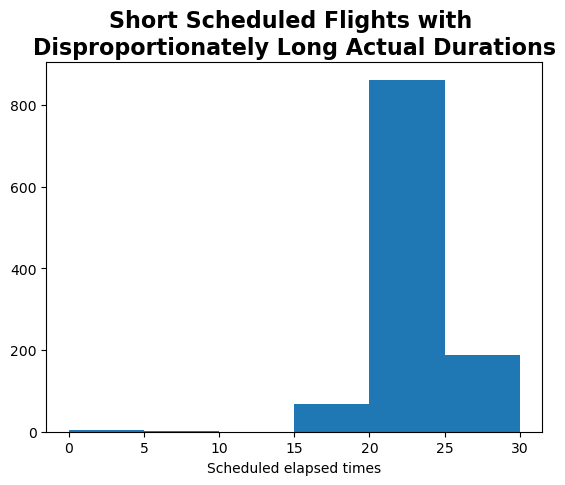

In [68]:
bins = np.arange(0, 35, 5)
plt.hist(flights[relative_diff_high_outliers & ET_less_30_min]['CRSElapsedTime'], bins = bins)
plt.xlabel('Scheduled elapsed times')
plt.title('Short Scheduled Flights with \nDisproportionately Long Actual Durations', fontsize = 16, fontweight = 'bold')
plt.show()

There are flights with a scheduled duration of less than 5 minutes (!!), but their actual elapsed time was much longer, marking them as outliers.

In [69]:
# Filtering the flights with Elapsed time less than 15, which relative difference of ETs is high
flights[relative_diff_high_outliers & (flights['CRSElapsedTime'] < 15)][rout_info + ['ActualElapsedTime']]

,Flight_Number_Reporting_Airline,Origin,Dest,CRSDepDT,CRSElapsedTime,ActualElapsedTime
18294052,5035,FWA,ORD,2017-03-29 19:24:00,4.0,67.0
19335470,7410,DTW,CIU,2017-05-22 15:10:00,1.0,83.0
26019611,5132,SLN,HYS,2018-06-02 17:10:00,5.0,42.0
26634021,5903,MTJ,DFW,2018-07-10 12:27:00,1.0,182.0
26989871,4493,MSP,LGA,2018-07-04 07:09:00,1.0,174.0
27319025,5123,CLT,PGV,2018-08-19 22:25:00,1.0,66.0


And these flights seem highly unusual due to their extremely short scheduled elapsed times. I plan to drop them.

In [70]:
flights = flights[~(relative_diff_high_outliers & (flights['CRSElapsedTime'] < 15))]

We have to recalculate the boarders for outliers because we deleted some records before

In [71]:
outlier_limit_low, outlier_limit_high = get_outliers_range(flights['RelElapTimeDiff'])

# Filtering flights that had actual elapsed time to short relative to scheduled 
relative_diff_low_outliers = (flights['RelElapTimeDiff'] < outlier_limit_low) 
relative_diff_high_outliers = (flights['RelElapTimeDiff'] > outlier_limit_high)
outliers = (flights['RelElapTimeDiff'] < outlier_limit_low) | (flights['RelElapTimeDiff'] > outlier_limit_high)

Outliers with a scheduled flight duration longer than 15 minutes

In [72]:
# Filtering the flights with Elapsed time between 15 and 20 minutes, which relative difference of ETs is high
with pd.option_context('display.max_rows', 70, 'display.width', 120):
    print(flights[relative_diff_high_outliers & (15 < flights['CRSElapsedTime']) & 
                  (flights['CRSElapsedTime'] < 20)][rout_info + ['ActualElapsedTime']])


          Flight_Number_Reporting_Airline Origin Dest            CRSDepDT  CRSElapsedTime  ActualElapsedTime
2435800                                65    WRG  PSG 2014-06-08 10:48:00            19.0               30.0
2437272                                65    WRG  PSG 2014-06-09 10:48:00            19.0               25.0
2437750                                65    WRG  PSG 2014-06-10 10:48:00            19.0               24.0
2438131                                65    WRG  PSG 2014-06-15 10:48:00            19.0               23.0
2443225                                65    WRG  PSG 2014-06-14 10:48:00            19.0               31.0
2935878                                65    WRG  PSG 2014-07-01 10:48:00            19.0               23.0
2939064                                65    WRG  PSG 2014-07-04 10:48:00            19.0               24.0
3004362                                65    WRG  PSG 2014-07-06 10:49:00            19.0               23.0
3100525            

These flights appear to be delayed but otherwise normal short flights, and I plan to keep them.

In [73]:
# Printing some summary for ALL OUTLIERS
print('In 2014-2018 there were {:,d} flights with relative ET difference out of range ({:.2%}, {:+.2%}%), which represent {:.2%} of total flights'
      .format(n:=len(flights[outliers]['Flight_Number_Reporting_Airline']), 
              outlier_limit_low, 
              outlier_limit_high, 
              n / len(flights)))

In 2014-2018 there were 1,442,509 flights with relative ET difference out of range (-25.30%, +16.78%%), which represent 4.79% of total flights


Some examples of lower ouliers

In [74]:
# Printing the TOP-10 fasterst flights
with pd.option_context('display.width', 200):
     print(flights[relative_diff_low_outliers][rout_info + ['ActualElapsedTime', 
                         'ElapsedTimeDiff',
                         'RelElapTimeDiff']]
          .sort_values('RelElapTimeDiff', ascending=True).head(10))
print('There are {:,d} flights which are low outliers'.format(len(flights[relative_diff_low_outliers])))

          Flight_Number_Reporting_Airline Origin Dest            CRSDepDT  CRSElapsedTime  ActualElapsedTime  ElapsedTimeDiff  RelElapTimeDiff
21568647                             5028    SBP  SFO 2017-10-09 08:55:00           302.0               52.0           -250.0        -0.827637
27060967                             5132    SLN  HYS 2018-07-17 05:40:00           161.0               44.0           -117.0        -0.726562
10814398                              969    SAN  SFO 2015-11-03 20:15:00           285.0               84.0           -201.0        -0.705078
24184719                             4528    MKE  DTW 2018-03-29 05:27:00           253.0               76.0           -177.0        -0.699707
24791714                             4456    PSP  SLC 2018-04-26 06:07:00           290.0               93.0           -197.0        -0.679199
5769493                              5621    MCN  ATL 2014-12-10 21:00:00            60.0               21.0            -39.0        -0.649902

Some data appears highly unusual: how is it possible that the flight (as shown in the first line of the example above) was scheduled for an elapsed time of 302 minutes, yet the airplane completed the journey from Origin to Destination in just 52 minutes? Let’s use visualization to analyze these cases.

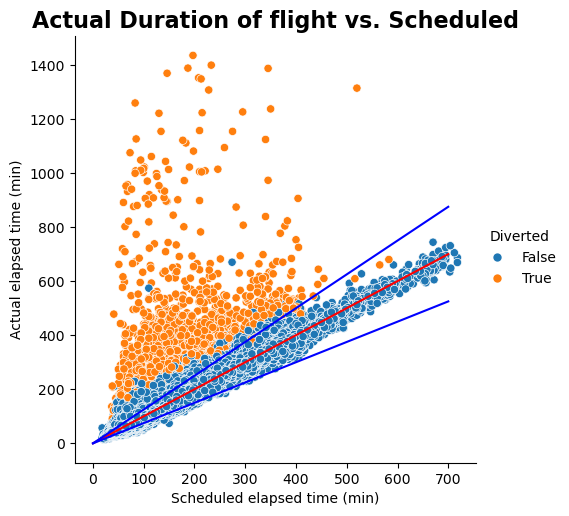

In [75]:
flights_sample = flights.sample(n=1000000)
sns.relplot(data=flights_sample,
            x='CRSElapsedTime', 
            y='ActualElapsedTime',
            hue='Diverted',
            kind='scatter')
plt.xlabel('Scheduled elapsed time (min)')
plt.ylabel('Actual elapsed time (min)')
line_x = [0, 700]
line_y = [0, 700]
line_up_x = [0, 700]
line_up_y = [0, 875]
line_down_x = [0, 700]
line_down_y = [0, 525]
plt.plot(line_x, line_y, color ='r')
plt.plot(line_up_x, line_up_y, color ='b')
plt.plot(line_down_x, line_down_y, color ='b')
plt.title('Actual Duration of flight vs. Scheduled', fontsize = 16, fontweight = 'bold')

plt.show()

In the graph above, the red line represents flights that arrived exactly on time (where the scheduled elapsed time equals the actual elapsed time). The blue lines indicate a +/-25% range around the scheduled times. We can draw a few conclusions:

1.	The shorter the scheduled time, the greater the dispersion of actual elapsed times around the scheduled time (red line).
2.	It may be worth considering the removal of these ‘super fast’ flights, as they are likely the result of scheduling errors.
3.	The distribution of differences appears skewed upward (in the context of the graph above), which makes sense given the presence of diverted flights that eventually reached their destination. Additionally, it is more common for flights to be delayed than to arrive significantly early due to technical limitations, such as maximum aircraft speed.

In [76]:
with pd.option_context('display.width', 400):
    print(flights[relative_diff_high_outliers][rout_info + ['ActualElapsedTime', 
                        'ElapsedTimeDiff',
                        'RelElapTimeDiff', 
                        'Diverted']].sort_values('RelElapTimeDiff', ascending = False).head(15))
print('There are {:,d} flights which are high outliers'.format(len(flights[relative_diff_high_outliers])))

          Flight_Number_Reporting_Airline Origin Dest            CRSDepDT  CRSElapsedTime  ActualElapsedTime  ElapsedTimeDiff  RelElapTimeDiff  Diverted
16181001                             2871    MEI  PIB 2016-10-23 20:50:00            31.0              898.0            867.0        27.968750      True
25390757                             5014    LWB  SHD 2018-05-14 19:20:00            35.0              879.0            844.0        24.109375      True
22637991                             5315    ORD  SBN 2017-12-26 19:45:00            54.0             1315.0           1261.0        23.359375      True
28968559                             5244    ATL  CSG 2018-11-08 17:06:00            44.0             1064.0           1020.0        23.187500      True
22245244                             4683    MSP  DLH 2017-11-17 12:50:00            57.0             1361.0           1304.0        22.875000      True
27061509                             5726    DEN  ASE 2018-07-17 14:22:00         

In [77]:
print(flights[relative_diff_high_outliers].groupby(['Cancelled', 'Diverted'])['Flight_Number_Reporting_Airline'].agg('count'))

Cancelled  Diverted
False      False       1123133
           True          60989
Name: Flight_Number_Reporting_Airline, dtype: int64


We see that there are 1,184,122 high outlier flights, and 60,989 of them were diverted. Let’s now focus on the flights that were not diverted.

In [78]:
with pd.option_context('display.width', 400):
    print(flights[relative_diff_high_outliers & (~flights['Diverted'])][rout_info + ['ActualElapsedTime', 
                        'ElapsedTimeDiff',
                        'RelElapTimeDiff', 
                        'Diverted']].sort_values('RelElapTimeDiff', ascending = False).head(15))
print('There are {:,d} flights which are high outliers'.format(len(flights[relative_diff_high_outliers 
                                                                           & (~flights['Diverted'])])))

          Flight_Number_Reporting_Airline Origin Dest            CRSDepDT  CRSElapsedTime  ActualElapsedTime  ElapsedTimeDiff  RelElapTimeDiff  Diverted
17604178                             2615    JAX  FLL 2017-01-06 11:47:00            77.0              453.0            376.0         4.882812     False
22534193                             2066    AVL  ATL 2017-12-17 11:58:00            64.0              370.0            306.0         4.781250     False
13649647                             1492    AUS  IAH 2016-05-27 15:01:00            59.0              318.0            259.0         4.390625     False
16646892                             3998    ORD  FSD 2016-11-27 00:05:00           110.0              574.0            464.0         4.218750     False
22533210                             1177    RDU  ATL 2017-12-17 12:40:00            96.0              487.0            391.0         4.074219     False
22534171                             2048    BTR  ATL 2017-12-17 12:10:00         

We see that there are 1,123,133 high outlier flights that were not diverted. These flights appear unusual, as they were scheduled for 77 minutes (as shown in the top line of the table above) but actually flew for 453 minutes, while Google indicates an 80-minute duration for this flight. I also plan to delete some of these records, but I will set less rigid criteria for deleting flights — specifically, +100% of the scheduled elapsed time.

In [79]:
relative_diff_low_outliers = (flights['RelElapTimeDiff'] < outlier_limit_low) 
relative_diff_high_outliers = (flights['RelElapTimeDiff'] > 1) & (~flights['Diverted'])
new_outliers = relative_diff_low_outliers | relative_diff_high_outliers

# Printing some summary for ALL OUTLIERS
print('In 2014-2018 there were {:,d} flights with relative ET difference out of range ({:.2%}, {:+.2%}%), which represent {:.2%} of total flights'
      .format(n:=len(flights[new_outliers]), 
              outlier_limit_low, 
              1, 
              n / (t := len(flights))))
# Printing some summary for LOW OUTLIERS
print('        of which {:,d} flights are low outliers ({:.2%})'.format(l := len(flights[relative_diff_low_outliers]), l / t))
# Printing some summary for ALL OUTLIERS
print('        of which {:,d} flights are high outliers ({:.2%})'.format(h := len(flights[relative_diff_high_outliers]), h / t))


In 2014-2018 there were 272,708 flights with relative ET difference out of range (-25.30%, +100.00%%), which represent 0.90% of total flights
        of which 258,387 flights are low outliers (0.86%)
        of which 14,321 flights are high outliers (0.05%)


In [80]:
print('Number of records BEFORE deleting outliers: {:,d}'.format(b := len(flights)))
flights = flights[(~relative_diff_low_outliers) & (~relative_diff_high_outliers)]
print('Number of records AFTER deleting outliers: {:,d}'.format(a := len(flights)))
print('Number fo records deleted: {:,d}'.format(b - a))

Number of records BEFORE deleting outliers: 30,144,192
Number of records AFTER deleting outliers: 29,871,484
Number fo records deleted: 272,708


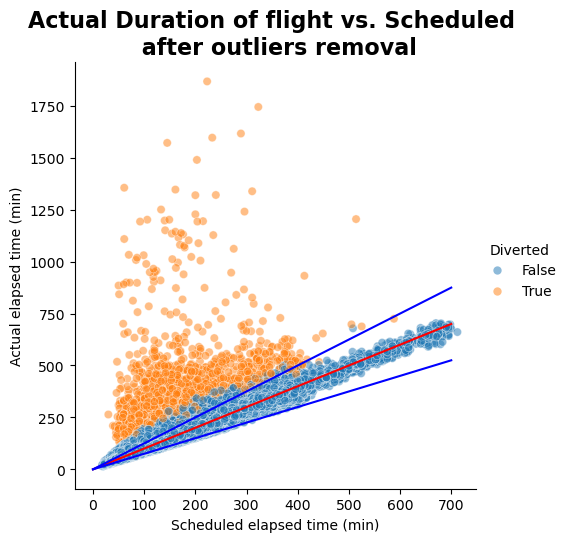

In [81]:
flights_sample = flights.sample(n=1000000)
sns.relplot(data=flights_sample,
            x='CRSElapsedTime', 
            y='ActualElapsedTime',
            hue='Diverted',
            kind='scatter', alpha=0.5)
plt.xlabel('Scheduled elapsed time (min)')
plt.ylabel('Actual elapsed time (min)')
line_x = [0, 700]
line_y = [0, 700]
line_up_x = [0, 700]
line_up_y = [0, 875]
line_down_x = [0, 700]
line_down_y = [0, 525]
plt.plot(line_x, line_y, color ='r')
plt.plot(line_up_x, line_up_y, color ='b')
plt.plot(line_down_x, line_down_y, color ='b')
plt.title('Actual Duration of flight vs. Scheduled \n after outliers removal', fontsize = 16, fontweight = 'bold')
plt.show()

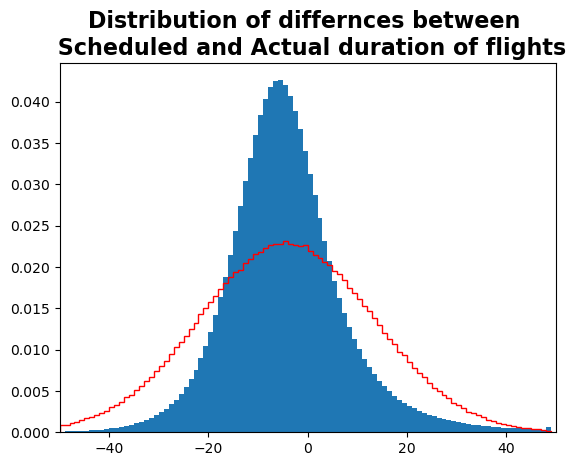

Mean difference between scheduled and actual time -4.2
Standard deviation of the difference 17.52


In [82]:
Act_vs_CRS_ET = flights['ElapsedTimeDiff']
Act_vs_CRS_ET = Act_vs_CRS_ET.astype(float)
sample_mean = Act_vs_CRS_ET.mean()
sample_std = Act_vs_CRS_ET.std()
rng = np.random.default_rng(18)
gauss_distr = rng.normal(sample_mean,
                        sample_std,
                        size=1000000)

bins = np.arange(-50,50)
plt.hist(Act_vs_CRS_ET, bins=bins, density=True)
plt.hist(gauss_distr, histtype='step', bins=bins, color='r', density=True)
plt.xlim(-50,50)
plt.title('Distribution of differnces between \n Scheduled and Actual duration of flights', fontsize = 16, fontweight = 'bold')
plt.show()

print('Mean difference between scheduled and actual time', round(sample_mean, 2))
print('Standard deviation of the difference', round(sample_std, 2))

The difference between scheduled and actual elapsed time is not normally distributed. On average, the actual elapsed time is less than the scheduled time by 4.2 minutes. However, this refers to the duration of the flight, not the arrival time.

How many flights have an elapsed time difference that is an outlier in the range?
To answer this question let's analyse the relative difference of elapsed time, because on long distances the absolute difference in minutes can be higher.

In [83]:
print('Mean relative difference between scheduled and actual time (%)', round(flights['RelElapTimeDiff'].mean() * 100, 2))
print('Standard deviation of the relative difference (%)', round(flights['RelElapTimeDiff'].std() * 100, 2))

Mean relative difference between scheduled and actual time (%) -2.94
Standard deviation of the relative difference (%) 14.37


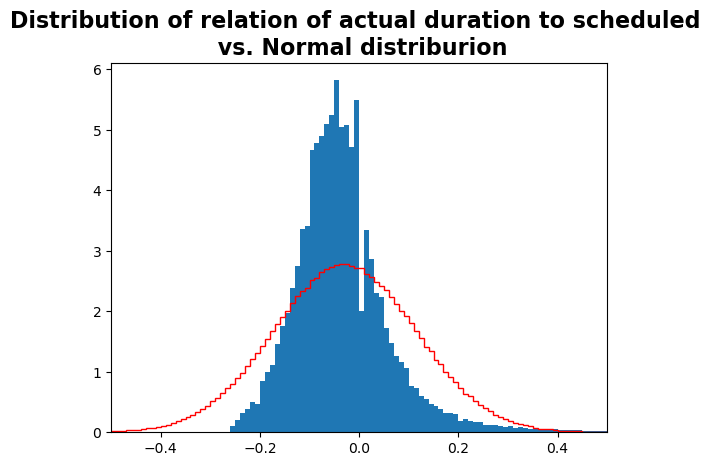

In [84]:
rng = np.random.default_rng(18)
gauss_distr = rng.normal(flights['RelElapTimeDiff'].mean(),
                        flights['RelElapTimeDiff'].std(),
                        size=1000000)

bins = np.arange(-1, 1, 0.01)

plt.hist(flights['RelElapTimeDiff'], bins=bins, density=True)
plt.hist(gauss_distr, histtype='step', bins=bins, color='r', density=True)
plt.xlim(-0.5, 0.5)

plt.title('Distribution of relation of actual duration to scheduled \n vs. Normal distriburion', fontsize = 16, fontweight = 'bold')
plt.show()

## Final data cleaning

I created some temporary columns needed to verify the dataset. Now that I have finished with data verification, rectifying, and cleaning, I can remove these temporary columns, along with some original columns that I retained for verification purposes.

In [85]:
flights = flights.drop(axis=1, columns=['diff_Act', 'diff_CRS', 'CRSElapsedTime', 'ActualElapsedTime', 'UTCElapsedTime_CRS',
                                 'UTCElapsedTime_Act', 'ElapsedTimeDiff', 'RelElapTimeDiff', 'ArrDelay','DepDelay'])

In [86]:
memory_usage_per_type(flights)
print(memory_usage(flights))

memory usage for number columns: 740.679 MB
memory usage for object columns: 227.901 MB
memory usage for datetimetz columns: 1139.507 MB
memory usage for category columns: 512.835 MB
memory usage for bool columns: 313.364 MB
2934.28688621521


## Calctulation of Prediction Variable for the Model

In [87]:
flights['ActArrDelay'] = (flights['ActArr_UTC'] - flights['CRSArr_UTC']).dt.total_seconds() / 60

In [88]:
print(flights['ActArrDelay'].describe())
print(flights['ActArrDelay'].isna().sum())

count    2.937768e+07
mean     5.556972e+00
std      4.653238e+01
min     -2.380000e+02
25%     -1.300000e+01
50%     -5.000000e+00
75%      8.000000e+00
max      3.288000e+03
Name: ActArrDelay, dtype: float64
493800


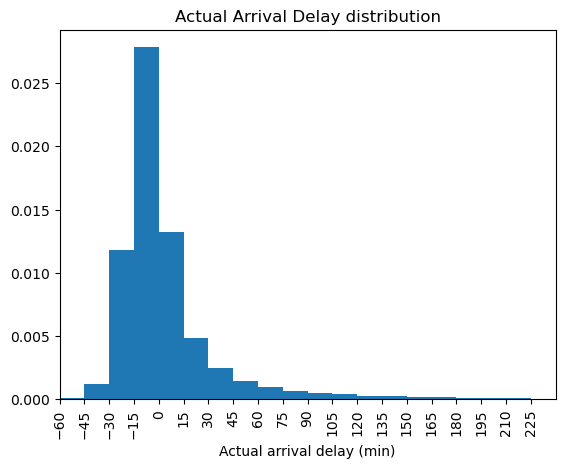

In [89]:
bins = np.arange(-60, 240, 15)
plt.hist(flights['ActArrDelay'], density=True, bins=bins)
plt.xlim(-60, 240)
plt.xticks(bins, rotation = 90)
plt.xlabel('Actual arrival delay (min)')
plt.title('Actual Arrival Delay distribution')
plt.show()

Let's examine some extreame Actual Arraval delay values

In [90]:
flights[flights['ActArrDelay'] < -60][['Flight_Number_Reporting_Airline', 'Origin',
                                       'CRSDepDT', 'CRSArrDT', 'DepDT', 'ArrDT', 
                                       'CRSDep_UTC', 'CRSArr_UTC', 'ActDep_UTC', 
                                       'ActArr_UTC', 'ActArrDelay']].sort_values(by = 'ActArrDelay')

,Flight_Number_Reporting_Airline,Origin,CRSDepDT,CRSArrDT,DepDT,ArrDT,CRSDep_UTC,CRSArr_UTC,ActDep_UTC,ActArr_UTC,ActArrDelay
21113614,559,ATL,2017-09-26 09:46:00,2017-09-26 13:23:00,2017-09-26 05:57:00,2017-09-26 09:25:00,2017-09-26 13:46:00+00:00,2017-09-26 17:23:00+00:00,2017-09-26 09:57:00+00:00,2017-09-26 13:25:00+00:00,-238.0
21116270,559,ATL,2017-09-27 09:46:00,2017-09-27 13:23:00,2017-09-27 05:52:00,2017-09-27 09:28:00,2017-09-27 13:46:00+00:00,2017-09-27 17:23:00+00:00,2017-09-27 09:52:00+00:00,2017-09-27 13:28:00+00:00,-235.0
21116233,506,SJU,2017-09-27 14:19:00,2017-09-27 18:05:00,2017-09-27 11:11:00,2017-09-27 14:43:00,2017-09-27 18:19:00+00:00,2017-09-27 22:05:00+00:00,2017-09-27 15:11:00+00:00,2017-09-27 18:43:00+00:00,-202.0
21095058,559,ATL,2017-09-25 09:46:00,2017-09-25 13:23:00,2017-09-25 06:25:00,2017-09-25 10:09:00,2017-09-25 13:46:00+00:00,2017-09-25 17:23:00+00:00,2017-09-25 10:25:00+00:00,2017-09-25 14:09:00+00:00,-194.0
21113577,506,SJU,2017-09-26 14:19:00,2017-09-26 18:05:00,2017-09-26 11:16:00,2017-09-26 15:12:00,2017-09-26 18:19:00+00:00,2017-09-26 22:05:00+00:00,2017-09-26 15:16:00+00:00,2017-09-26 19:12:00+00:00,-173.0
...,...,...,...,...,...,...,...,...,...,...,...
16462705,23,JFK,2016-11-09 10:30:00,2016-11-09 13:50:00,2016-11-09 10:28:00,2016-11-09 12:49:00,2016-11-09 15:30:00+00:00,2016-11-09 21:50:00+00:00,2016-11-09 15:28:00+00:00,2016-11-09 20:49:00+00:00,-61.0
23185379,3455,MCI,2018-01-13 07:00:00,2018-01-13 09:00:00,2018-01-13 06:39:00,2018-01-13 07:59:00,2018-01-13 13:00:00+00:00,2018-01-13 17:00:00+00:00,2018-01-13 12:39:00+00:00,2018-01-13 15:59:00+00:00,-61.0
21429654,11,EWR,2017-09-15 16:00:00,2017-09-15 19:20:00,2017-09-15 15:52:00,2017-09-15 18:19:00,2017-09-15 20:00:00+00:00,2017-09-16 02:20:00+00:00,2017-09-15 19:52:00+00:00,2017-09-16 01:19:00+00:00,-61.0
18144074,438,JFK,2017-03-19 08:00:00,2017-03-19 11:05:00,2017-03-19 07:58:00,2017-03-19 10:04:00,2017-03-19 12:00:00+00:00,2017-03-19 18:05:00+00:00,2017-03-19 11:58:00+00:00,2017-03-19 17:04:00+00:00,-61.0


In [91]:
print('There are {:,d} flights that arrived more than 60 minutes earlier.'.format(len(flights[flights['ActArrDelay'] < -60])))
print('and {:,d} flights that arrived more than 240 minutes (4 hours) later'.format(len(flights[flights['ActArrDelay'] > 240])))


There are 3,283 flights that arrived more than 60 minutes earlier.
and 146,176 flights that arrived more than 240 minutes (4 hours) later


Although it seems unusual (especially arriving 238 minutes earlier), this data is accurate, as these flights had earlier actual departures (a negative departure delay). Therefore, I plan to keep and use this data.

In [92]:
# import pickle 

# input_file_name = '../data/processed/processed_2014_2018_final.pickle'
# with open(input_file_name, 'rb') as in_file:
#     flights = pickle.load(in_file)

In [93]:
flights['Flight_Number_Reporting_Airline'] = flights['Flight_Number_Reporting_Airline'].astype('category')
flights['ReachedDest'] = (~flights['Cancelled']) & (~flights['Diverted'] | flights['DivReachedDest'])
flights['Weekday'] = flights['CRSDepDT'].dt.dayofweek.astype('int8')
flights['Month'] = flights['CRSDepDT'].dt.month.astype('int8')

In [94]:
# Searching for missed Actual Arrived Delays among actually arrived flights
actually_arrived_flights = (~flights['Cancelled'] & ~(flights['Diverted'] & ~flights['DivReachedDest']))
ind = flights.loc[actually_arrived_flights & flights['ActArrDelay'].isna()].index
with pd.option_context('display.width', 400):
    print(flights.loc[ind])

         Reporting_Airline Flight_Number_Reporting_Airline Origin Dest DepartureDelayGroups DepTimeBlk ArrivalDelayGroups ArrTimeBlk  Cancelled CancellationCode  ...               DepDT  ArrDT                CRSDep_UTC                CRSArr_UTC                ActDep_UTC  ActArr_UTC  ActArrDelay  ReachedDest  Weekday  Month
18948325                F9                             920    MCO  TTN                    2  2000-2059                NaN  2300-2359      False              NaN  ... 2017-04-04 21:10:00    NaT 2017-04-05 00:35:00+00:00 2017-04-05 03:12:00+00:00 2017-04-05 01:10:00+00:00         NaT          NaN         True        1      4

[1 rows x 32 columns]


In [95]:
flights.drop(index = ind, axis = 0, inplace = True)

In [96]:

output_file_name = home_dir / 'data' / 'processed' / 'processed_2014_2018_final.pickle'
with open(output_file_name, 'wb') as out_file:
    pickle.dump(flights, out_file, protocol=pickle.HIGHEST_PROTOCOL)

## Conclusions

1.	The dataset is mostly accurate and comprehensive.  
  
2.	The data relevant for the project has been selected, and the proposed data type for each field has been determined. The total size of the dataset has been optimized, reducing memory usage to less than 3 GB (from an initial estimate of 81 GB).  
  
3.	The data was verified by checking the consistency between scheduled and actual elapsed times, along with scheduled and actual departure and arrival times. To achieve this, the time data (in HHMM format) was converted into minutes, and date data was enriched 
by incorporating time zones obtained from the IATA codes of the origin and destination airports, then converted to UTC time.  
  
4.	During verification, several types of errors were rectified where possible, such as inconsistencies between differences in departure and arrival times and the corresponding flight duration (elapsed time).  
  
5.	Data for flights with confirmed errors that could not be corrected—such as those with inconsistent departure/arrival times and flight durations, or flights with actual elapsed times more than twice the scheduled elapsed time—was deleted. The total amount of deleted data did not exceed 2% of the original dataset.  
  
6.	The prediction variable, the actual arrival delay, for the model has been calculated.  
  
7.	The resulting dataset has been exported in .pickle format.  
